# Spectroscopy Processing: (Part 1 Background)
This is divided into two parts
1. Some background and an informal analysis of the signal characteristics measured in an MRS experiment
2. Processing the measured signal to produce spectra for the purpose of quantifying relative contributions from fat/water.

## Setup

### Python Imports
`numpy` for numerical calculations/functions, and `matplotlib` for plotting.

In [3]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline

### Generic plotting function
Just to simplify things later on for plotting and adding titles

In [4]:
def plot_with_titles(x, y, maintitle="", xlabel="", ylabel="", xlim=None, ylim=None, **kwargs):
    p = plt.plot(x, y, **kwargs)
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if maintitle is not None:
        plt.title(maintitle)

## Informal analysis of signal characteristics
In a STEAM MRS experiment, the target region (voxel) is excited to produce a stimulated echo. Typically, the later 1/2 of the echo is "recorded" for analysis and is referred to as _free induction decay_ or FID. First a mathematical model of a generic FID signal is introduced.

### Mathematical Model

The `fid_resonance` function is designed to simulate a fid signal (as measured in _time_) containing a single resonance source, given by

$$
f_r(t) = A\ \underbrace{\exp\left(-\alpha t\right)}_{\textrm{Exponential}}\ \underbrace{\exp\left(-\left(\beta t\right)^2\right)}_{\textrm{Gaussian}}\ \exp\left(2 \pi i f t + \phi_0\right),
$$
where $\alpha$ and $\beta$ are parameters determining the contribution of exponential and gaussian decay, respectively; $f$ is the frequency of the resonance signal in Hertz; $t$ is time in seconds; and $\phi_0$ is the initial phase of the resonance in radians.

In [5]:
def fid_resonance(t, amp, alpha, beta, f, phi0):
    '''
    Simulate a FID with gaussian/exponential lineshape:
     t : time(s)
     amp: amplitude area under the spectrum of this resonance
     alpha: exponential envelope contribution
     beta: gaussian envelope contribution
     f: frequency of resonance (Hz)
     phi0: initial phase of resonance
    '''

    envelope = amp * np.exp(-alpha*t) * np.exp(-(beta*t)**2)
    signal = envelope * np.exp(1j * (2*np.pi*f*t + phi0))
    
    signal[0] = signal[0] / 2.025 # first point correction
    # add some phase
    #signal = np.roll(signal, -1)
    
    return signal

Using that model it is possible to create data having the characteristcs normally seen in-vivo, and to inspect the individual contributions from each resonance.

### Constants Used in Calculations

#### Acquisition constants / parameters

In [6]:
gamma_bar = 42.58 # Mhz/T (of 1H)
field_str = 3.0   # T
acq_bw = 2000.0   # 1.0/sec -> samples per second.
num_pts = 2048    # number of points to acquire
acq_te = 54.0     # ms

# Simulation parameters
alpha = 60.0      # exponential contribution
beta = 40.0       # gaussian contribution

# other possibilities
#alpha = 0.0      # exponential contribution
#beta = 60.0       # gaussian contribution

#### Resonance characteristics
Since the frequencies are field-dependent, the `ppm` scale is typically used to denote [chemical shift locations](http://mriquestions.com/f-w-chemical-shift.html). The `ppm` scale removes any dependence on field, and so for example the $\mathrm{CH_2}$ peak of fat appears at -3.4 ppm on any MRI system, but in terms of frequency it appears at -434.3 Hz at 3 T and -217.15 Hz at 1.5 T.

In [7]:
# The resonances of the fat spectrum (used in Dixon model)
ppm_templ  = np.array([ 5.3, 4.13, 2.78, 2.24, 2.03, 1.57, 1.3, 0.9 ]) - 4.7
freq_templ = ppm_templ * gamma_bar * field_str # convert to frequency @ field_str
freq_templ = np.insert(freq_templ, 0, 0) # insert water at center frequency (0)

fat_fraction = 0.60
water_amp = (1.0 - fat_fraction)/fat_fraction

# each resonance may have its own inherent T2
t2s_templ  = [ 30.0, 38.7, 25.4, 41.5, 41.9, 41.9, 41.9, 46.0, 71.4 ]

# but for this example, just fix them to all having the same T2
#t2s_templ  = np.repeat(30.0, len(t2s_templ))

amps_templ = [ water_amp, 0.065934, 0.034965, 0.010989, 0.051948, 0.076923, 0.046953, 0.597403, 0.114885 ]

# apply the T2 weighting to the amplitudes
amps_weighted = np.array(amps_templ) * np.exp(-acq_te/np.array(t2s_templ))

# Normalize so that total(amps_weighted) = 1.0
amps_weighted = amps_weighted/amps_weighted.sum()

### Generate the time-domain signal

First, a time axis `t` is descretized starting from time = 0 to time = (length of measurement), providing the sample points for each FID value. 
Each frequency specified in `freq_templ` is scaled by the coorsponding ampliture in `amps_templ`.

In [8]:
t = np.arange(num_pts, dtype=np.float)/acq_bw # total time = [(# of samples) * (time for one sample)]

Next, the time series $f_k(t)$ for each frequency ($k$ from 0 to `len(freqs_templ)`) is calculated. The function `fid_resonance` returns the values for a single frequency. The amplitudes in `amps_templ` determine the contribute of each frequency to the overall FID.

In [10]:
# make an array to hold the fid for each resonance to keep them separate.
f_k = np.ndarray(shape=(num_pts, len(freq_templ)), dtype=np.complex)

for i, amp in enumerate(amps_weighted):
    print("Generating signal for %dth resonance at %+0.2f Hz with amplitude %0.2f" % (i, freq_templ[i], amp))
    f_k[:,i] = fid_resonance(t, amps_weighted[i], alpha, beta, freq_templ[i], 0.0)

Generating signal for 0th resonance at +0.00 Hz with amplitude 0.26
Generating signal for 1th resonance at +76.64 Hz with amplitude 0.04
Generating signal for 2th resonance at -72.81 Hz with amplitude 0.01
Generating signal for 3th resonance at -245.26 Hz with amplitude 0.01
Generating signal for 4th resonance at -314.24 Hz with amplitude 0.03
Generating signal for 5th resonance at -341.07 Hz with amplitude 0.05
Generating signal for 6th resonance at -399.83 Hz with amplitude 0.03
Generating signal for 7th resonance at -434.32 Hz with amplitude 0.44
Generating signal for 8th resonance at -485.41 Hz with amplitude 0.13


### Display the results, per resonance
While not typically possible in real experiments, the simulation permits viewing the signal characteristics for each resonance source. It is easy to differentiate visually the low frequency resonances from high frequency resonances. The envelope function (plotted in orange) highlights the signal decay. Try exploring these results for various $\alpha$ and $\beta$ values.

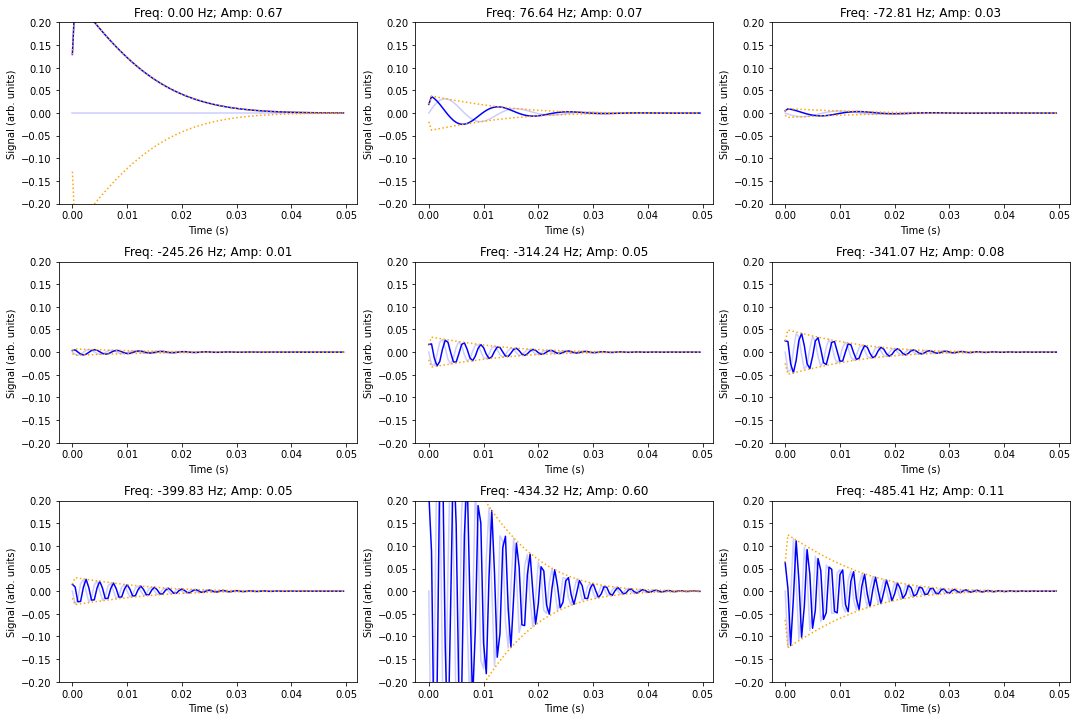

In [11]:
f = plt.figure(figsize=(15,13))
for i in range(len(freq_templ)):
    plt.subplot(4, 3, i+1, )
    fid = f_k[:,i]
    p = plt.plot(t[0:100], np.real(fid[0:100]), color='blue')
    p = plt.plot(t[0:100], np.imag(fid[0:100]), color='#0000FF33')
    # note that the envelope is the magnitude at each point.
    p = plt.plot(t[0:100], np.abs(fid[0:100]), linestyle=':', color='orange')
    p = plt.plot(t[0:100], -np.abs(fid[0:100]), linestyle=':', color='orange')
    plt.ylim(-0.2,0.2)
    plt.title('Freq: %0.2f Hz; Amp: %0.2f' % (freq_templ[i], amps_templ[i]))
    plt.xlabel('Time (s)')
    plt.ylabel('Signal (arb. units)')
f.tight_layout()

### Display the final result

The final FID consists of a superposition (sum) of the resonance signals from each frequency:

$$
f(t) = \sum_{r=1}^k A_r \exp\left(-\alpha t\right)\ \exp\left(-\left(\beta t\right)^2\right)\ \exp\left(2 \pi i f_r t + \phi_0\right)
$$


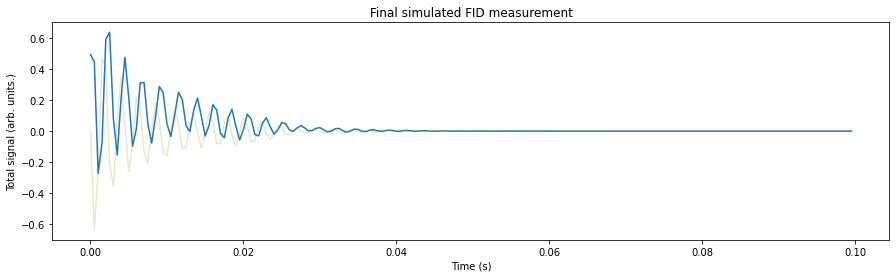

In [14]:
f = plt.figure(figsize=(15,4))

f_total = f_k.sum(axis=1) # Add up the FIDs

plot_with_titles(t[0:200], np.real(f_total)[0:200], 
                 xlabel="Time (s)", ylabel="Total signal (arb. units.)", 
                 maintitle="Final simulated FID measurement")
plt.plot(t[0:200], np.imag(f_total)[0:200], color='#80900033')

Compare the above with some real data measured from a human leg muscle with a disease that causes healthy muscle tissue to be replaced by fat.

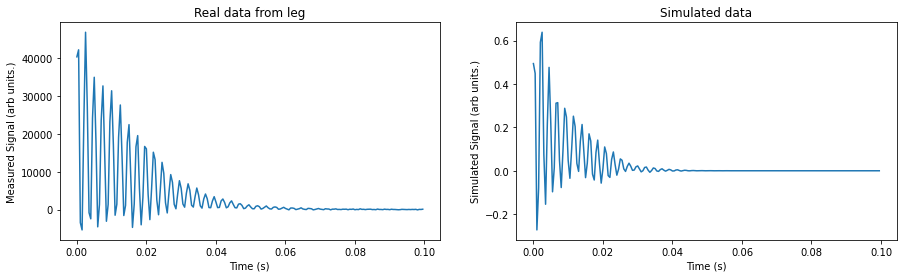

In [15]:
import pandas as pd
f = plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
df = pd.read_csv('./Simulated_FID_Example_invivo_data.csv')

# perform a slight phase correction, estimated by eyeballing the data.
y = (df.re_fid + 1j * df.im_fid) * np.exp(1j * np.pi * 1.99)

plot_with_titles(df.x_time_ms[0:200], np.real(y)[0:200], 
                xlabel="Time (s)", ylabel="Measured Signal (arb units.)", 
                 maintitle="Real data from leg")
plt.subplot(1,2,2)
plot_with_titles(t[0:200], np.real(f_total)[0:200], 
                xlabel="Time (s)", ylabel="Simulated Signal (arb units.)", 
                 maintitle="Simulated data")

Hopefully the visual similarities between these two FIDs are apparent, despite one being generated from a model (right) and one acquired in-vivo (left).